In [4]:
# ---------------------------------------------------------------------
# basic os stuff
# ---------------------------------------------------------------------
from pathlib import Path       # use instead of os.path and glob
import logging                 # use logging instead of print
import sys

# ---------------------------------------------------------------------
# datastructures and scientific computing
# ---------------------------------------------------------------------
import yaml
import numpy as np                       # arrays
import scipy as sp                       # useful functions


# ---------------------------------------------------------------------
# plotting routines
# ---------------------------------------------------------------------
import matplotlib as mpl
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# astronomy related stuff
# ---------------------------------------------------------------------

from astropy.table import Table,QTable   # useful datastructure
from astropy.table import vstack, join   # combine multiple tables
from astropy.nddata import NDData, StdDevUncertainty, Cutout2D  

from astropy.io import ascii,fits        # open text and fits files

from astropy.wcs import WCS              # handle coordinates
from astropy.coordinates import SkyCoord # convert pixel to sky coordinates
from astropy.coordinates import match_coordinates_sky
import astropy.units as u

from reproject import reproject_interp


logging.basicConfig(stream=sys.stdout,datefmt='%H:%M:%S',level=logging.INFO)
logger = logging.getLogger(__name__)

basedir  = Path('..')
data_ext = Path('a:') 

In [5]:
def read_associations(folder,target,scalepc,HSTband='nuv',version='v1p2',data='all'):
    '''read the catalogue and spatial mask for the associations
    
    see cluster.io for full documentation
    '''
    
    folder = folder/f'associations_{version}'
    target_folder = folder/f'{target}_{HSTband}'
    folder = target_folder/f'{scalepc}pc'

    # first the association catalogue
    catalogue_file = folder / f'{target}_phangshst_associations_{HSTband}_ws{scalepc}pc_{version}.fits'
    with fits.open(catalogue_file) as hdul:
        associations = Table(hdul[1].data)

    # modify table (rename the columns such that the clusters and associations are identical)
    associations['SkyCoord'] = SkyCoord(associations['reg_ra']*u.degree,associations['reg_dec']*u.degree)
    associations.rename_columns(['reg_id','reg_ra','reg_dec','reg_x','reg_y',
                                'reg_dolflux_Age_MinChiSq','reg_dolflux_Mass_MinChiSq','reg_dolflux_Ebv_MinChiSq',
                                'reg_dolflux_Age_MinChiSq_err','reg_dolflux_Mass_MinChiSq_err','reg_dolflux_Ebv_MinChiSq_err'],
                                ['assoc_ID','RA','DEC','X','Y','age','mass','EBV','age_err','mass_err','EBV_err'])
    for col in list(associations.columns):
        if col.endswith('mjy'):
            associations[f'{col.split("_")[0]}_FLUX'] = 1e20*associations[col]*u.mJy.to(u.erg/u.s/u.cm**2/u.Hz)
        if col.endswith('mjy_err'):
            associations[f'{col.split("_")[0]}_FLUX_ERR'] = 1e20*associations[col]*u.mJy.to(u.erg/u.s/u.cm**2/u.Hz)

    # next the spatial masks for the associations
    mask_file = folder / f'{target}_phangshst_associations_{HSTband}_ws{scalepc}pc_idmask_{version}.fits'
    with fits.open(mask_file) as hdul:
        mask = hdul[0].data.astype(float)
        mask[mask==0] = np.nan
        associations_mask = NDData(mask,
                                mask=mask==0,
                                meta=hdul[0].header,
                                wcs=WCS(hdul[0].header))


    return associations, associations_mask

In [106]:
name='NGC3627'
version='v1p2'
scalepc=32
HSTband='nuv'


#p = {x:sample_table.loc[name][x] for x in sample_table.columns}

# DAP linemaps (Halpha and OIII)
filename = data_ext / 'MUSE_DR2.1' / 'MUSEDAP' / f'{name}_MAPS.fits'
with fits.open(filename) as hdul:
    Halpha = NDData(data=hdul['HA6562_FLUX'].data,
                    uncertainty=StdDevUncertainty(hdul['HA6562_FLUX_ERR'].data),
                    mask=np.isnan(hdul['HA6562_FLUX'].data),
                    meta=hdul['HA6562_FLUX'].header,
                    wcs=WCS(hdul['HA6562_FLUX'].header))
    OIII = NDData(data=hdul['OIII5006_FLUX'].data,
                    uncertainty=StdDevUncertainty(hdul['OIII5006_FLUX_ERR'].data),
                    mask=np.isnan(hdul['OIII5006_FLUX'].data),
                    meta=hdul['OIII5006_FLUX'].header,
                    wcs=WCS(hdul['OIII5006_FLUX'].header)) 

# the original catalogue from Francesco
with fits.open(basedir / 'data' / 'interim' / 'Nebulae_Catalogue_v2p1.fits') as hdul:
    nebulae = Table(hdul[1].data)
nebulae['SkyCoord'] = SkyCoord(nebulae['cen_ra']*u.deg,nebulae['cen_dec']*u.deg,frame='icrs')

with fits.open(basedir/'data'/'interim'/f'Nebulae_Catalogue_v2p1_dig.fits') as hdul:
    dig = Table(hdul[1].data)

with fits.open(basedir/'data'/'interim'/f'Nebulae_Catalogue_v2p1_fuv.fits') as hdul:
    fuv = Table(hdul[1].data)

with fits.open(basedir/'data'/'interim'/f'Nebulae_Catalogue_v2p1_eq.fits') as hdul:
    eq_width = Table(hdul[1].data)

nebulae = join(nebulae,fuv,keys=['gal_name','region_ID'])
nebulae = join(nebulae,eq_width,keys=['gal_name','region_ID'])
nebulae = join(nebulae,dig,keys=['gal_name','region_ID'])
nebulae.rename_columns(['cen_x','cen_y'],['x','y'])

with np.errstate(divide='ignore',invalid='ignore'):
    nebulae['[SIII]/[SII]'] = np.nan
    SII = nebulae['SII6716_FLUX_CORR']+nebulae['SII6730_FLUX_CORR']
    SIII = nebulae['SIII6312_FLUX_CORR']+nebulae['SIII9068_FLUX_CORR']
    nebulae[SII>0]['[SIII]/[SII]'] = SIII[SII>0]/SII[SII>0]
    nebulae['HA/FUV'] = nebulae['HA6562_FLUX_CORR']/nebulae['FUV_FLUX_CORR']
    nebulae['HA/FUV_err'] = nebulae['HA/FUV']*np.sqrt((nebulae['HA6562_FLUX_CORR_ERR']/nebulae['HA6562_FLUX_CORR'])**2+(nebulae['FUV_FLUX_CORR_ERR']/nebulae['FUV_FLUX_CORR'])**2)

nebulae = filter_table(nebulae,gal_name=name)
nebulae.add_index('region_ID')

filename = data_ext / 'MUSE_DR2.1' / 'Nebulae catalogue' /'spatial_masks'/f'{name}_nebulae_mask.fits'
with fits.open(filename) as hdul:
    nebulae_mask = NDData(hdul[0].data.astype(float),mask=Halpha.mask,meta=hdul[0].header,wcs=WCS(hdul[0].header))
    nebulae_mask.data[nebulae_mask.data==-1] = np.nan


print(f'{name}: {len(nebulae)} HII-regions in final catalogue')


target  = name.lower()

associations, associations_mask = read_associations(folder=data_ext/'HST'/'stellar_associations',                             
                                                    target=target,scalepc=scalepc,
                                                    HSTband=HSTband,version=version,data='all')


print(f'{name}: {len(associations)} associations in catalogue')

NGC3627: 1635 HII-regions in final catalogue
NGC3627: 1415 associations in catalogue


In [110]:
nebulae_hst, _  = reproject_interp(nebulae_mask,
                                output_projection=associations_mask.wcs,
                                shape_out=associations_mask.data.shape,
                                order='nearest-neighbor')    

# we scale the associations such that the the id is in the decimal
scale = 10**np.ceil(np.log10(max(associations_mask.data[~np.isnan(associations_mask.data)])))
s_arr = associations_mask.data/scale+nebulae_hst

print(f'masks reprojected')

# ids of associations, nebulae and combination (sum) of both
a_id = np.unique(associations_mask.data[~np.isnan(associations_mask.data)]).astype(int)
n_id = np.unique(nebulae_mask.data[~np.isnan(nebulae_mask.data)]).astype(int)
s_id = np.unique(s_arr[~np.isnan(s_arr)])

# this splits the sum into two parts (nebulae and associations)
a_modf,n_modf = np.modf(s_id)
n_modf = n_modf.astype(int)
a_modf = np.round(a_modf*scale).astype(int)

unique_a, count_a = np.unique(a_modf,return_counts=True)
unique_n, count_n = np.unique(n_modf,return_counts=True)

nebulae_dict = {int(n) : a_modf[n_modf==n].tolist() for n in n_id}     
associations_dict = {int(a) : n_modf[a_modf==a].tolist() for a in a_id}     


# so far we ensured that the nebulae in unique_n have only one association,
# but it is possible that this association goes beyond the nebulae and into
# a second nebulae. Those objects are excluded here
isolated_nebulae = set()
isolated_assoc   = set()
for n,v in nebulae_dict.items():
    if len(v)==1:
        if len(associations_dict[v[0]])==1:
            isolated_nebulae.add(n)
            isolated_assoc.add(v[0])

print(f'n_associations = {len(associations_dict)}')
print(f'n_nebulae      = {len(nebulae_dict)}')
print(f'1to1 match     = {len(isolated_nebulae)}')


# we save those two dicts so we do not have to redo this everytime
with open(basedir/'data'/'map_nebulae_association'/version/f'{name}_{HSTband}_{scalepc}pc_nebulae.yml','w+') as f:
    yaml.dump(nebulae_dict,f)
with open(basedir/'data'/'map_nebulae_association'/version/f'{name}_{HSTband}_{scalepc}pc_associations.yml','w+') as f:
    yaml.dump(associations_dict,f)

MemoryError: Unable to allocate 2.92 GiB for an array with shape (196000000, 2) and data type float64

In [4]:
# find all assoc that have at least one pixel outside of the nebulae masks
mask = associations_mask.data.copy()
mask[~np.isnan(nebulae_hst)] = np.nan
outside = np.unique(mask[~np.isnan(mask)].astype(int))

# find all assoc that have at least one pixel inside of the nebulea masks
mask = associations_mask.data.copy()
mask[np.isnan(nebulae_hst)] = np.nan
inside = np.unique(mask[~np.isnan(mask)].astype(int))

contained = np.setdiff1d(inside,outside)
partial   = np.intersect1d(inside,outside)
isolated  = np.setdiff1d(outside,inside)

print(f'contained: {len(contained)}\npartial: {len(partial)}\nisolated: {len(isolated)}')

assoc_tmp = associations[['assoc_ID']].copy()
assoc_tmp.add_index('assoc_ID')

#x_asc,y_asc = associations['SkyCoord'].to_pixel(env_masks_neb.wcs)
#outside = (x_asc > env_masks_neb.data.shape[1]) | (y_asc > env_masks_neb.data.shape[0])
#x_asc[outside] = 0
#y_asc[outside] = 0
#assoc_tmp['env_asc'] = [environment_dict[env_masks_neb.data[y,x]] for 
#                        x,y in zip(x_asc.astype(int),y_asc.astype(int))]
#assoc_tmp[outside]['env_asc'] = ''

assoc_tmp['overlap'] = np.empty(len(associations),dtype='U9')
assoc_tmp['overlap'][np.isin(assoc_tmp['assoc_ID'],contained)] = 'contained'
assoc_tmp['overlap'][np.isin(assoc_tmp['assoc_ID'],partial)]   = 'partial'
assoc_tmp['overlap'][np.isin(assoc_tmp['assoc_ID'],isolated)]  = 'isolated'
assoc_tmp['1to1'] = False
assoc_tmp['1to1'][np.isin(assoc_tmp['assoc_ID'],list(isolated_assoc))] = True
assoc_tmp['Nnebulae'] = [len(associations_dict[k]) for k in assoc_tmp['assoc_ID']]

assoc_tmp['region_ID'] = np.nan
assoc_tmp['region_ID'][assoc_tmp['1to1']] = [associations_dict[k][0] for k in assoc_tmp[assoc_tmp['1to1']]['assoc_ID']]

overlap = join(
    Table(np.unique(associations_mask.data[~np.isnan(associations_mask.data)],return_counts=True),names=['assoc_ID','size']),
    Table(np.unique(associations_mask.data[~np.isnan(nebulae_hst) & ~np.isnan(associations_mask.data)],return_counts=True),names=['assoc_ID','overlap_size']),
    keys=['assoc_ID'],join_type='outer')
overlap = overlap.filled(0)
overlap['overlap_asc'] = overlap['overlap_size']/overlap['size']
overlap['overlap_asc'].info.format = '%.2f'
assoc_tmp = join(assoc_tmp,overlap[['assoc_ID','overlap_asc']],keys='assoc_ID')

print('write to file')
hdu = fits.BinTableHDU(assoc_tmp,name='joined catalogue')
hdu.writeto(basedir/'data'/'map_nebulae_association'/version/f'{name}_{HSTband}_{scalepc}pc_associations.fits',overwrite=True)


contained: 211
partial: 631
isolated: 621
write to file


In [5]:
from cluster.regions import find_neighbors
from tqdm import tqdm 

nebulae_tmp = nebulae[['region_ID','x','y']].copy()
nebulae_tmp.add_index('region_ID')

#nebulae_tmp['env_neb'] = [environment_dict[env_masks_neb.data[y,x]] for 
#                          x,y in zip(nebulae_tmp['x'].astype(int),nebulae_tmp['y'].astype(int))]

nebulae_tmp['neighbors'] = np.nan
for row in tqdm(nebulae_tmp):
    row['neighbors'] = len(find_neighbors(nebulae_mask.data,tuple(row[['x','y']]),row['region_ID'],plot=False))
del nebulae_tmp[['x','y']]

nebulae_tmp['1to1'] = False
nebulae_tmp['1to1'][np.isin(nebulae_tmp['region_ID'],list(isolated_nebulae))] = True
nebulae_tmp['Nassoc'] = [len(nebulae_dict[k]) for k in nebulae_tmp['region_ID']]
nebulae_tmp['assoc_ID'] = np.nan
nebulae_tmp['assoc_ID'][nebulae_tmp['1to1']] = [nebulae_dict[k][0] for k in nebulae_tmp[nebulae_tmp['1to1']]['region_ID']]


overlap = join(
    Table(np.unique(nebulae_hst[~np.isnan(nebulae_hst)],return_counts=True),names=['region_ID','size']),
    Table(np.unique(nebulae_hst[~np.isnan(nebulae_hst) & ~np.isnan(associations_mask.data)],return_counts=True),names=['region_ID','overlap_size']),
    keys=['region_ID'],join_type='outer')
overlap = overlap.filled(0)
overlap['overlap_neb'] = overlap['overlap_size']/overlap['size']
overlap['overlap_neb'].info.format = '%.2f'
nebulae_tmp = join(nebulae_tmp,overlap[['region_ID','overlap_neb']],keys='region_ID')

hdu = fits.BinTableHDU(nebulae_tmp,name='joined catalogue')
hdu.writeto(basedir/'data'/'map_nebulae_association'/version/f'{name}_{scalepc}pc_nebulae.fits',overwrite=True)
#del nebulae_tmp['1to1']

print(f'{np.sum(nebulae_tmp["neighbors"]==0)} nebulae have no neighbors')

100%|████████████████████████████████████████████████████████████████████████████| 2869/2869 [00:02<00:00, 1056.80it/s]


1934 nebulae have no neighbors


In [8]:


catalogue = join(assoc_tmp,nebulae_tmp,keys=['assoc_ID','region_ID'])
catalogue = join(catalogue,nebulae,keys='region_ID')
catalogue = join(catalogue,associations,keys='assoc_ID')

# pay attention to the order of assoc, neb
catalogue.rename_columns(['X','Y','x','y','RA','DEC','cen_ra','cen_dec',
                          'reg_area','region_area',
                          'EBV_1','EBV_2','EBV_err','EBV_ERR',
                          'SkyCoord_1','SkyCoord_2'],
                         ['x_asc','y_asc','x_neb','y_neb','ra_asc','dec_asc','ra_neb','dec_neb',
                          'area_asc','area_neb',
                          'EBV_balmer','EBV_stars','EBV_balmer_err','EBV_stars_err',
                          'SkyCoord_asc','SkyCoord_neb'])

# separation to other associations and nebulae
idx,sep_asc,_= match_coordinates_sky(catalogue['SkyCoord_asc'],associations['SkyCoord'],nthneighbor=2)
idx,sep_neb,_= match_coordinates_sky(catalogue['SkyCoord_neb'],nebulae['SkyCoord'],nthneighbor=2)
catalogue['sep_asc'] = sep_asc.to(u.arcsec)
catalogue['sep_neb'] = sep_neb.to(u.arcsec)

# select the columns of the joined catalogue
columns = ['assoc_ID','region_ID','x_asc','y_asc','x_neb','y_neb',
           'ra_asc','dec_asc','ra_neb','dec_neb','SkyCoord_asc','SkyCoord_neb',
           'area_asc','area_neb',
           'sep_asc','sep_neb','neighbors','Nassoc','overlap','overlap_asc','overlap_neb',
           'age','age_err','mass','mass_err','EBV_stars','EBV_stars_err','EBV_balmer','EBV_balmer_err',
           'met_scal','met_scal_err','logq_D91','logq_D91_err',] + \
            [x for x in nebulae.columns if x.endswith('_FLUX_CORR')] + \
            [x for x in nebulae.columns if x.endswith('_FLUX_CORR_ERR')] + \
            ['NUV_FLUX','NUV_FLUX_ERR','U_FLUX','U_FLUX_ERR','B_FLUX','B_FLUX_ERR',
             'V_FLUX','V_FLUX_ERR','I_FLUX','I_FLUX_ERR'] + \
            ['HA/FUV','eq_width']
catalogue = catalogue[columns]
        
catalogue.rename_columns([col for col in catalogue.columns if col.endswith('FLUX_CORR')],
                      [col.replace('FLUX_CORR','flux') for col in catalogue.columns if col.endswith('FLUX_CORR')])
catalogue.rename_columns([col for col in catalogue.columns if col.endswith('FLUX_CORR_ERR')],
                      [col.replace('FLUX_CORR_ERR','flux_err') for col in catalogue.columns if col.endswith('FLUX_CORR_ERR')])
catalogue['assoc_ID'] = catalogue['assoc_ID'].astype('int')
catalogue['region_ID'] = catalogue['region_ID'].astype('int')

catalogue.info.description = 'Joined catalogue between associations and nebulae'
mean_sep = np.mean(catalogue['SkyCoord_asc'].separation(catalogue['SkyCoord_neb']))
print(f'{len(catalogue)} objects in catalogue')
print(f'the mean separation between cluster and association center is {mean_sep.to(u.arcsecond):.2f}')

426 objects in catalogue
the mean separation between cluster and association center is 0.61 arcsec


In [105]:
export = catalogue.copy() #[catalogue['contained']]
#export.add_column(export['SkyCoord_asc'].to_string(style='hmsdms',precision=2),index=6,name='RaDec_asc')
#export.add_column(export['SkyCoord_neb'].to_string(style='hmsdms',precision=2),index=8,name='RaDec_neb')

RA_asc ,DEC_asc = zip(*[x.split(' ') for x in export['SkyCoord_asc'].to_string(style='hmsdms',precision=2)])
RA_neb ,DEC_neb = zip(*[x.split(' ') for x in export['SkyCoord_neb'].to_string(style='hmsdms',precision=2)])

export.add_column(RA_asc,index=6,name='Ra_asc')
export.add_column(DEC_asc,index=8,name='Dec_asc')
export.add_column(RA_neb,index=10,name='Ra_neb')
export.add_column(DEC_neb,index=12,name='Dec_neb')

for col in export.columns:
    if col not in ['Ra_asc','Dec_asc','Ra_neb','Dec_neb','region_ID','cluster_ID','overlap']:
        export[col].info.format = '%.2f'

del export[['ra_asc','dec_asc','ra_neb','dec_neb','SkyCoord_neb','SkyCoord_asc','HA/FUV']]

hdu = fits.BinTableHDU(export,name='joined catalogue')
hdu.writeto(basedir/'data'/'map_nebulae_association'/version/f'{name}_{HSTband}_{scalepc}pc_associations_and_nebulae_joined.fits',overwrite=True)

## others


measure Halpha in association masks

In [4]:
import pyneb
gal_name = 'NGC0628'

EBV_MW = {'IC5332': 0.015,'NGC0628': 0.062,'NGC1087': 0.03,'NGC1300': 0.026,
          'NGC1365': 0.018,'NGC1385': 0.018,'NGC1433': 0.008,'NGC1512': 0.009,
          'NGC1566': 0.008,'NGC1672': 0.021,'NGC2835': 0.089,'NGC3351': 0.024,
          'NGC3627': 0.037,'NGC4254': 0.035,'NGC4303': 0.02,'NGC4321': 0.023,
          'NGC4535': 0.017,'NGC5068': 0.091,'NGC7496': 0.008}
rc_MW = pyneb.RedCorr(E_BV = EBV_MW[gal_name], R_V = 3.1, law = 'CCM89 oD94')

In [9]:
from pathlib import Path
import sys
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

from astropy.io import ascii, fits
from astropy.table import Table 
from astropy.nddata import NDData, StdDevUncertainty
from astropy.wcs import WCS
import astropy.units as u 
from astropy.coordinates import SkyCoord

import pyneb
from reproject import reproject_exact, reproject_interp


gal_name = 'NGC0628'
version  = 'v1p2'
HSTband  = 'nuv'
scalepc  = 32

# the folder with the data (structure similar to Google Drive)
data_ext = Path('a:')/'Archive'

EBV_MW = {'IC5332': 0.015,'NGC0628': 0.062,'NGC1087': 0.03,'NGC1300': 0.026,
          'NGC1365': 0.018,'NGC1385': 0.018,'NGC1433': 0.008,'NGC1512': 0.009,
          'NGC1566': 0.008,'NGC1672': 0.021,'NGC2835': 0.089,'NGC3351': 0.024,
          'NGC3627': 0.037,'NGC4254': 0.035,'NGC4303': 0.02,'NGC4321': 0.023,
          'NGC4535': 0.017,'NGC5068': 0.091,'NGC7496': 0.008}


print(f'reading MUSE data for {gal_name}')
filename = data_ext / 'MUSE'/'DR2.1'/'MUSEDAP'/f'{gal_name}_MAPS.fits'
with fits.open(filename) as hdul:
    Halpha = NDData(data=hdul['HA6562_FLUX'].data,
                    uncertainty=StdDevUncertainty(hdul['HA6562_FLUX_ERR'].data),
                    mask=np.isnan(hdul['HA6562_FLUX'].data),
                    meta=hdul['HA6562_FLUX'].header,
                    wcs=WCS(hdul['HA6562_FLUX'].header))
    Hbeta = NDData(data=hdul['HB4861_FLUX'].data,
                    uncertainty=StdDevUncertainty(hdul['HB4861_FLUX_ERR'].data),
                    mask=np.isnan(hdul['HB4861_FLUX'].data),
                    meta=hdul['HB4861_FLUX'].header,
                    wcs=WCS(hdul['HB4861_FLUX'].header))


print(f'reading HST data for {gal_name}')
folder=data_ext/'Products'/'stellar_associations'/f'associations_{version}'/f'{gal_name.lower()}_{HSTband}'/f'{scalepc}pc'
# first the association catalogue
catalogue_file = folder / f'{gal_name.lower()}_phangshst_associations_{HSTband}_ws{scalepc}pc_{version}.fits'
with fits.open(catalogue_file) as hdul:
    associations = Table(hdul[1].data)

# modify table (rename the columns such that the clusters and associations are identical)
associations['SkyCoord'] = SkyCoord(associations['reg_ra']*u.degree,associations['reg_dec']*u.degree)
associations.rename_column('reg_id','assoc_ID')

mask_file = folder / f'{gal_name.lower()}_phangshst_associations_{HSTband}_ws{scalepc}pc_idmask_{version}.fits'
with fits.open(mask_file) as hdul:
    mask = hdul[0].data.astype(float)
    mask[mask==0] = np.nan
    associations_mask = NDData(mask,
                            mask=mask==0,
                            meta=hdul[0].header,
                            wcs=WCS(hdul[0].header))


reading MUSE data for NGC0628
reading HST data for NGC0628


In [23]:
from skimage.measure import find_contours
from regions import PixCoord, PolygonPixelRegion
from functools import reduce

def region_from_mask(mask):
    
    # otherwiese we have problems with the edge of the image
    mask[:,0] = False
    mask[:,-1] = False
    mask[0,:] = False
    mask[-1,:] = False
    
    contours = find_contours(mask.astype(float),level=0.5)
    
    regs = []
    for contour in contours:
        regs.append(PolygonPixelRegion(PixCoord(*contour.T[::-1])))
     
    return regs
    #return reduce(lambda x,y:x&y,regs)

assoc_ID = 524
reg = region_from_mask(np.isin(associations_mask.data,assoc_ID))
reg_pix_hst = reduce(lambda x,y:x|y,reg)
reg_sky = reg_pix_hst.to_sky(associations_mask.wcs)
reg_pix_muse = reg_sky.to_pixel(Halpha.wcs)

In [ ]:
from astropy.nddata import Cutout2D
from astropy.visualization import simple_norm

fig,ax=plt.subplots(figsize=(8,8))

position = associations[associations['assoc_ID']==assoc_ID]['SkyCoord']
cutout=Cutout2D(Halpha.data,position,size=20*u.arcsec,wcs=Halpha.wcs)

norm = simple_norm(cutout.data,clip=False,percent=99)
ax.imshow(cutout.data,norm=norm,cmap=plt.cm.Greys,origin='lower')

#mask = (env_masks_neb.data==6).astype(float)
#mask[mask==0.] = np.nan
#ax.imshow(mask,alpha=0.5,origin='lower')

reg_pix_muse = reg_sky.to_pixel(cutout.wcs)
patch = reg_pix_muse.as_artist()
ax.add_patch(patch)
    

ax.axis('off')

plt.show()

In [43]:
np.sum(mask.multiply(cutout.data))

104687.37103612526

In [40]:
np.sum(mask.multiply(cutout.data))

107960.30029335656

In [44]:
print(f'reprojecting data')
Halpha_repro = reproject_exact(Halpha,output_projection=associations_mask.wcs,
                               shape_out=associations_mask.data.shape,return_footprint=False)
Hbeta_repro = reproject_exact(Hbeta,output_projection=associations_mask.wcs,
                               shape_out=associations_mask.data.shape,return_footprint=False)

reprojecting data


C:\Users\fabian\miniconda3\envs\pymuse\lib\site-packages\reproject\spherical_intersect\core.py:49: UserWarning: The reproject_exact function currently has precision issues with images that have resolutions below ~0.05 arcsec, so the results may not be accurate.
  "arcsec, so the results may not be accurate.", UserWarning)
C:\Users\fabian\miniconda3\envs\pymuse\lib\site-packages\reproject\spherical_intersect\core.py:49: UserWarning: The reproject_exact function currently has precision issues with images that have resolutions below ~0.05 arcsec, so the results may not be accurate.
  "arcsec, so the results may not be accurate.", UserWarning)


In [54]:
Halpha_flux = np.array([np.sum(Halpha_repro[associations_mask.data==assoc_ID]) for assoc_ID in associations['assoc_ID']])

In [75]:
from tqdm import tqdm

Halpha_from_mask = []
for assoc_ID in tqdm(associations['assoc_ID']):
    
    position = associations[associations['assoc_ID']==assoc_ID]['SkyCoord']
    try:
        cutout_Halpha=Cutout2D(Halpha.data,position,size=12*u.arcsec,wcs=Halpha.wcs)
    except:
        Halpha_from_mask.append(np.nan)
        continue
    cutout_mask=Cutout2D(associations_mask.data,position,size=12*u.arcsec,wcs=associations_mask.wcs)

    # in rare cases this will return multiple regions
    reg_pix_hst = region_from_mask(np.isin(cutout_mask.data,assoc_ID))[0]
    reg_sky = reg_pix_hst.to_sky(cutout_mask.wcs)
    reg_pix_muse = reg_sky.to_pixel(cutout_Halpha.wcs)
    mask = reg_pix_muse.to_mask(mode='subpixels',subpixels=16)
    
    Halpha_from_mask.append(np.sum(mask.multiply(cutout_Halpha.data)))

100%|██████████████████████████████████████████████████████████████████████████████| 1463/1463 [01:35<00:00, 15.26it/s]


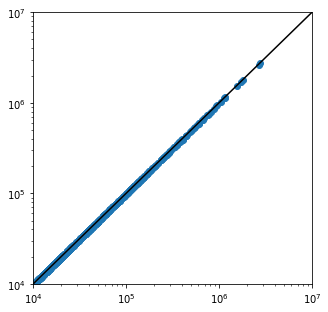

In [79]:
fig,ax=plt.subplots(figsize=(5,5))

ax.scatter(Halpha_flux/25,Halpha_from_mask)
ax.plot([1e4,1e7],[1e4,1e7],color='black')
ax.set(xscale='log',yscale='log',xlim=[1e4,1e7],ylim=[1e4,1e7])

plt.show()